In this notebook we will reproduce some of the key findings from Henaff et al. Geodesics of Learned Representations

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

import os.path as op

from plenoptic.tools import conv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In sequences of natural images, objects often undergo smooth affine transformations (rotation, translation, dilation, etc.) as a result of either their own or the viewer's motion. While these motions are simple in a conceptual sense, they are actually quite complicated in terms of their high dimensional pixel representations. Consider the case below of an image translating at a constant velocity (so called "ground truth,") compared with a constant velocity linear interpolation between the first and final images. 

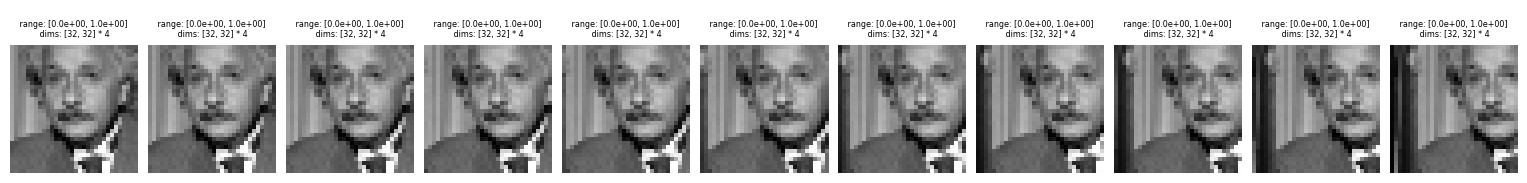

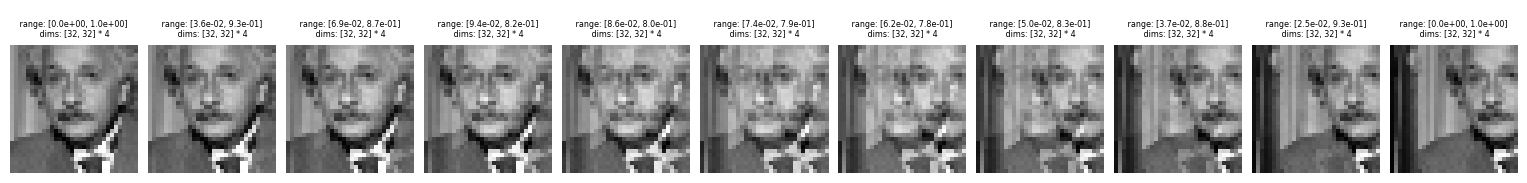

In [22]:
image_size = 64
einstein = po.load_images('../data/256/einstein.pgm')
einstein = po.tools.conv.blur_downsample(einstein, step=(4,4))
vid = po.tools.translation_sequence(einstein[0])
from torchvision.transforms.functional import center_crop
vid = center_crop(vid, image_size // 2)
vid = po.tools.rescale(vid, 0, 1)

imgA = vid[0:1]
imgB = vid[-1:]

video_linear = np.zeros_like(vid)
for i in range(11):
    video_linear[i, :, :] = imgA + (i / 10.) * (imgB - imgA)

# convention: full name for numpy arrays, short hands for torch tensors
video_truth = to_numpy(vid).squeeze()
# pt.animshow(video, zoom=4)
pt.imshow(list(video_truth.squeeze()), zoom=4);
pt.imshow(list(video_linear.squeeze()), zoom=4);

Since the two videos are not the same, we say that translation is not a linear operation in pixel space, or alternatively that the pixel representation does not linearize translation. The module geodesic.py provides a way of probing a representation to determine what transformations *are* linearized by a given representation by synthesizing a sequence of images that correspond to the straightest possible line between two anchor images (related by some transformation of interest) in the representation space. (This needs a drawing IMO). 

As a first example let's consider the case where are representation is simply the Fourier amplitude spectrum of an image.

In [23]:
import torch.fft
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
        
    def spectrum(self, x):
        return torch.fft.rfftn(x, dim=(2, 3))

    def forward(self, x):
        if self.representation == 'amp':
            return torch.abs(self.spectrum(x))
        elif self.representation == 'phase':
            return torch.angle(self.spectrum(x))
        elif self.representation == 'rectangular':
            return self.spectrum(x)
        elif self.representation == 'polar':
            return torch.cat((torch.abs(self.spectrum(x)),
                              torch.angle(self.spectrum(x))),
                             dim=1)

model = Fourier('amp')

In [24]:
# synthesize an image sequence corresponding to a geodesic connecting imgA and imgB in Fourier amplitude space
n_steps = len(video)-1
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='bridge')
moog.synthesize(max_iter=500, learning_rate=.01, lmbda=.1)

100%|██████████| 500/500 [00:03<00:00, 126.40it/s, loss=8.6704e+01, gradient norm=8.4500e+00, lr=0.01]


We can analyze the geodesic sequence in two key ways. The first being to see how much the sequence varies from a straight line in representation space. These values can be compared to the line generated in representation space via linear interpolation in pixel space and the line generated by the ground truth transformation sequence. And the second being qualitative inspection of the geodesic sequence.

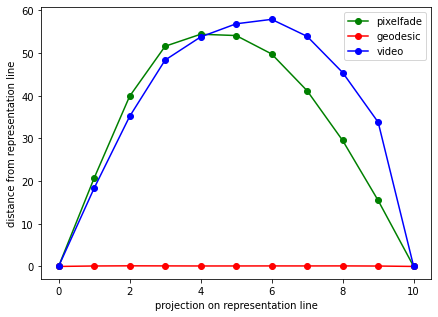

In [29]:
moog.plot_distance_from_line(vid);

We can see that even though the representation does not linearize the transformation (the video line does not correspond to linear interpolation in the representation space) we can still find a geodesic sequence connecting the the two images in representation space (the geodesic line is a straight line, as its distance from the linear interpolation line is zero everywhere). This shows that rather than insufficient invariance to translation (as in the case of the pixel representation), the Fourier amplitude representation actually has *excess* invariance. This is due to the fact that we discarded the phase information. 

This excess invariance can also be made clear by visually inspecting the synthesized geodesic sequence.

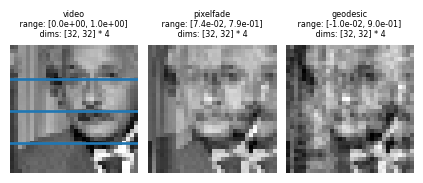

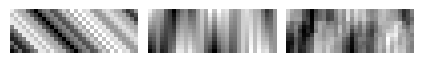

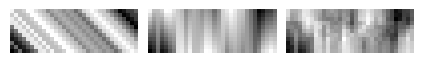

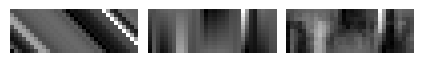

In [31]:
pixelfade = to_numpy(moog.pixelfade.squeeze())
geodesic = to_numpy(moog.geodesic.squeeze())
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4);

size = geodesic.shape[-1]
h, m , l = (size//2 + size//4, size//2, size//2 - size//4)

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=4);

Besides as a visualization tool for probing the structure of a learned representation, Henaff et al. demonstrated that geodesic sequences could be used as a diagnostic tool for improving deep neural networks. Namely after noticing that geodesic sequences generated from the VGG16 classification model suffered from aliasing artifacts, they showed that replacing max pooling layers with L2 pooling alleviated this issue. This analysis is reproduced below.

In [38]:
# download pretrained with defaults
vgg16 = models.vgg16(pretrained=True)

In [39]:
# an L2 pooling layer we will use to replace max pooling
class L2Pool2d(nn.Module):
    def __init__(self, verbose=False):
        super(L2Pool2d, self).__init__()
        
    def forward(self, x):
        # square, blur, downsample, sqrt
        out = x ** 2
        out = conv.blur_downsample(out) # this is a stride 2 convolution w/ blurring kernel
        out = out ** 0.5
        
        return out        

In [49]:
# a modification that uses L2 pooling rather than max pooling
class vggL2(nn.Module):
    def __init__(self, vgg16):
        super(vggL2, self).__init__()
        self.base = vgg16
        self.L2Pool2d = L2Pool2d()
        
        self.features = nn.Sequential(
            self.base.features[0:4], 
            self.L2Pool2d,
            self.base.features[5:9], 
            self.L2Pool2d,
            self.base.features[10:16], 
            self.L2Pool2d,
            self.base.features[17:23], 
            self.L2Pool2d,
            self.base.features[24:30],
            self.L2Pool2d  
        )
        self.avgpool = self.base.avgpool
        self.classifier = self.base.classifier
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

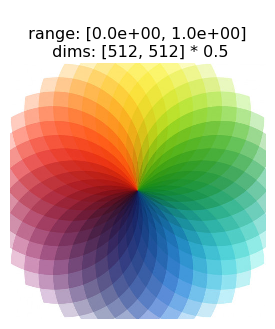

In [44]:
# load a color image for VGG16
def center_crop(im, n):
    """Crop an nxn image from the center of im"""
    im_height, im_width = im.shape[:2]
    assert n<im_height and n<im_width

    im_crop = im[im_height//2-n//2:im_height//2+n//2,
              im_width//2-n//2:im_width//2+n//2]
    return im_crop

n = 512 # this will be the img_height and width of the input, you can change this to accommodate your machine
img = plt.imread(op.join('../data', 'color_wheel.jpg')).copy()

# center crop the image to nxn
img = center_crop(img, n)

img = po.rescale(img)  # rescale to [0, 1]

img_A = torch.as_tensor(img, dtype=torch.float).unsqueeze(0).permute((0,3,1,2)) # permute to (b, c, h, w)
po.imshow(img_A, as_rgb=True, zoom=0.5);